In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from functools import reduce
from operator import mul
import sys
from collections import Counter
InteractiveShell.ast_node_interactivity = "all"
# np.set_printoptions(threshold=np.inf)


In [2]:
#--- dimensions of the cropped and aligned card 
dpi = 300
card_width = 750
card_height = 1050
card_area = card_height*card_width
card_forgivness = 10

path = './input/'
output_path = './output/'
input_filename = 'cards.jpg'
output_filename = 'card'
file_num = 0
rot_ang = .7

    
#-- Functions for application
def get_lap(image):
    lap = cv2.Laplacian(image, cv2.CV_64F)
    return np.uint8(np.absolute(lap))

def get_sobel(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    return cv2.bitwise_or(sobelx, sobely)
 
def get_canny(image):
    return cv2.Canny(image, 155, 175)

def adaptive_threshold(image):
    # return cv2.GaussianBlur(image, (50,50), 0)
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,199, 5)

def get_dpi(filename, min_dpi=180):
    global dpi
    global card_width
    global card_height
    global card_area
    try:
        im = Image.open(filename)
        dpi_info = im.info.get('dpi')
        if dpi_info:
            dpi = round(sum(dpi_info)/2)
        else:
            print("DPI information not found in the image metadata.")
    except FileNotFoundError:
        print("Error file not found.")
        sys.exit()
    if dpi < min_dpi:
        dpi = min_dpi
    card_width = dpi * 2.5
    card_height = dpi * 3.5
    card_area = card_height * card_width
    print(f"Image DPI: {dpi}")
    print(f"Image HxW: {card_height}x{card_width}")
    print(f"Card Area: {card_area}")

def drawRectangle(frame, bbox, thickness=1):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), thickness, 1)

def drawBoundingBox(image, box, thickness=1):
    box = np.intp(box)
    cv2.drawContours(image, [box],0,(255, 0, 0),thickness)

def get_crop(image, cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    return image[y:y+h, x:x+w]

def get_crop_wh(image,x=0,y=0,w=card_width,h=card_height):
    return image[y:y+h, x:x+w]

def get_outline(image, old_cnt):
    #--- convert to grayscale ---
    imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # cv2.imshow('im_gray_result', imgray)
    #--- perform Otsu threshold to binarize the image (black and white) ---
    ret2, th2 = cv2.threshold(imgray,220,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #--- only finding the external contours ---
    contours, _ =    cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    if cnt is not None:
        print(cv2.boundingRect(cnt))
        print(cv2.contourArea(old_cnt), cv2.contourArea(cnt), (card_width*card_height))
        # cv2.imshow('im_outline_result', get_crop(image, cnt))
        return cnt
    return old_cnt

def save_image(image, filename = output_filename, file_ext = '.png' ):
    global file_num
    file_num += 1
    cv2.imwrite(output_path + filename + str(file_num) + file_ext, image)
    return

def dist2target_dim(box, target_width=card_width, target_height=card_height):
    """
    Calculates the "distance" between a bounding box's dimensions and target dimensions.

    Args:
        box: A tuple (x1, y1, x2, y2) representing the bounding box.
        target_width: The target width.
        target_height: The target height.

    Returns:
        The Euclidean distance between the box's dimensions and the target dimensions.
    """
    box_width = box[2] - box[0]
    box_height = box[3] - box[1]
    return np.sqrt((box_width - target_width)**2 + (box_height - target_height)**2)

def getSubImage(base_src, rect):
    src = base_src.copy()
    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D( center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, M, (src.shape[0],src.shape[1]))
    out = cv2.getRectSubPix(dst, size, center)
    return out

def getSubImageAndRotate(base_src, cnt, rect):
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_image = base_src[y:y+h, x:x+w]
    (height, width) = cropped_image.shape[:2]
    center = (width // 2, height // 2)

    # Get center, size, and angle from rect
    _, size, theta = rect
    
    # Convert to int 
    size = tuple(map(int, [card_width, card_height]))
    print("Size", size)
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D( center, theta, 1)
    # Perform rotation on src image
    print("M:", M)
    dst = cv2.warpAffine(cropped_image, M, (width, height))
    out = cv2.getRectSubPix(dst, size, center)
    return out

def show_image(image, grey=True):
    plt.figure()
    plt.axis('off')
    if grey:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def get_contours(image, canvas):
    shapes = []
    if len(image.shape) == 2:
        #--- only finding the external contours ---
        tmp_canvas = canvas.copy()
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            cnt_area = cv2.contourArea(c)
            if (cnt_area > card_area * .9 and cnt_area < card_area * 1.1):
                print(card_area, cv2.contourArea(c))
                shapes.append(c)
                min_rect = cv2.minAreaRect(c)
                print("Info: ", min_rect)
                if min_rect[2] > 80:
                    min_rect = (min_rect[0],min_rect[1],min_rect[2]-90)
                drawBoundingBox(tmp_canvas,cv2.boxPoints(min_rect),20)
                show_image(getSubImageAndRotate(canvas, c, min_rect),False)

        print(len(shapes))
        return tmp_canvas
    else:
        print(len(shapes))
        return image

def get_threshold(image, white_bg=False):
    if white_bg:
        return cv2.threshold(cv2.bitwise_not(image),1,255,0)[1]
    else:
        return cv2.threshold(image,100,255,0)[1]   

def get_background_color(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Flatten the image to a 1D array
    pixels = image.reshape((-1, 3))

    # Find the most common color
    color_counts = Counter(tuple(pixel) for pixel in pixels)
    most_common_color = color_counts.most_common(1)[0][0]

    return most_common_color

Image DPI: 180
Image HxW: 630.0x450.0
Card Area: 283500.0
283500.0 300553.0
Info:  ((2289.993408203125, 1742.46533203125), (469.3684997558594, 647.6333618164062), 0.2658717930316925)
Size (450, 630)
M: [[ 0.99998923  0.00464032 -1.50556364]
 [-0.00464032  0.99998923  1.09861494]]
283500.0 294147.5
Info:  ((1283.474609375, 1729.595947265625), (464.6891784667969, 639.086181640625), 0.6902772188186646)
Size (450, 630)
M: [[ 0.99992743  0.01204732 -3.85013501]
 [-0.01204732  0.99992743  2.85441539]]
283500.0 290652.0
Info:  ((280.0414733886719, 1714.9796142578125), (461.4056701660156, 639.7218627929688), 0.4735080301761627)
Size (450, 630)
M: [[ 0.99996585  0.00826418 -2.64487926]
 [-0.00826418  0.99996585  1.92825158]]
283500.0 293757.5
Info:  ((2779.710205078125, 1067.0751953125), (464.6903991699219, 640.5023193359375), 0.32646816968917847)
Size (450, 630)
M: [[ 0.99998377  0.00569791 -1.8252317 ]
 [-0.00569791  0.99998377  1.33852266]]
283500.0 278893.5
Info:  ((1780.828857421875, 1053.

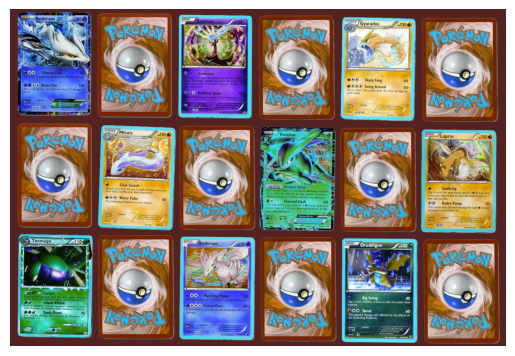

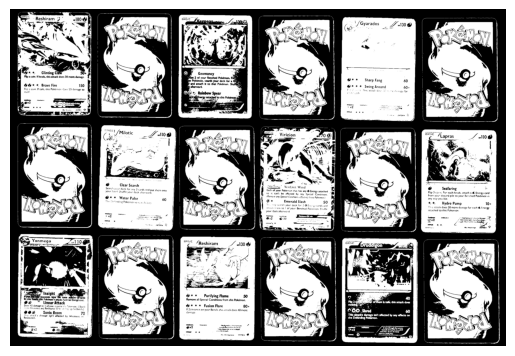

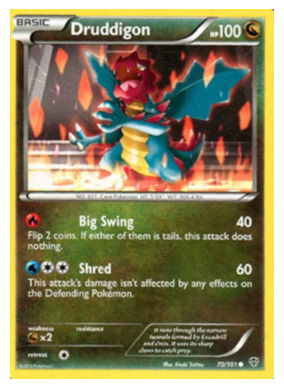

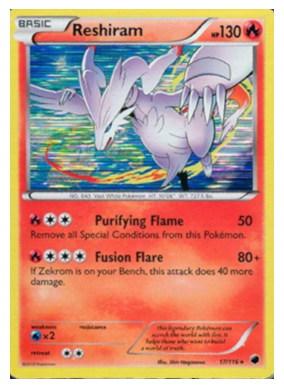

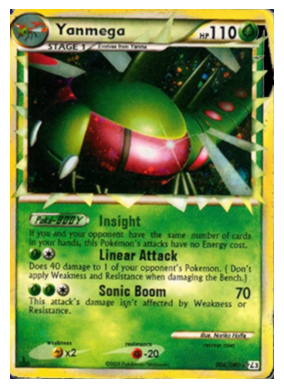

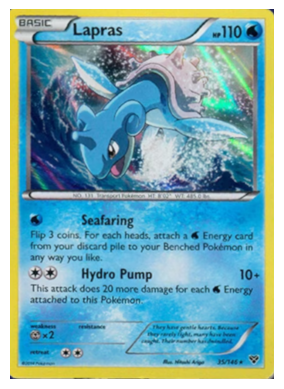

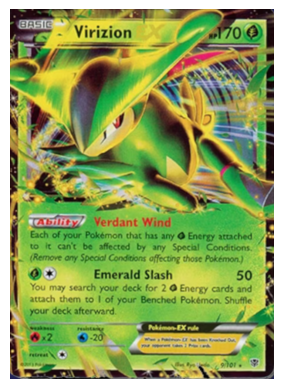

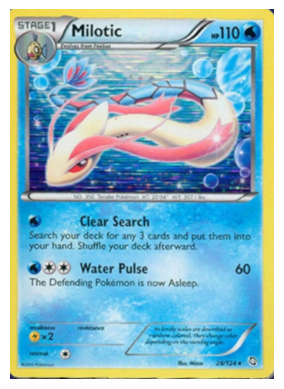

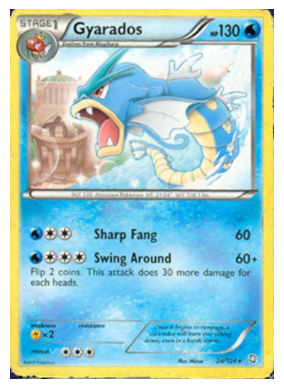

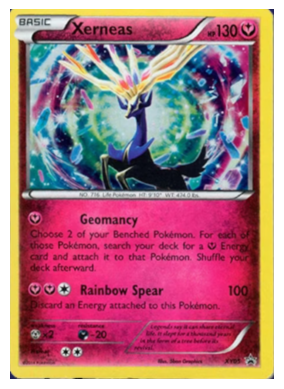

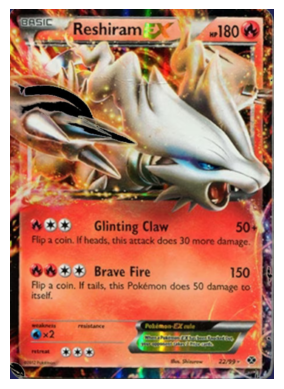

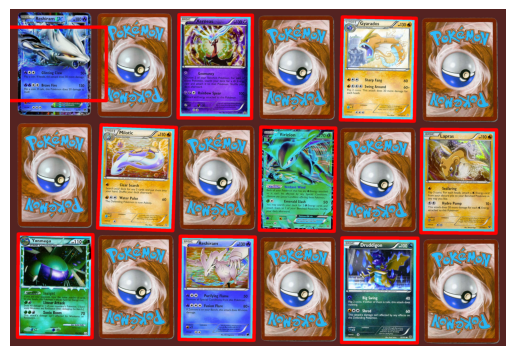

In [4]:
filename = 'input/full_deck.jpg'
cb_img = cv2.imread(filename)
canvas = cb_img.copy()

# inv_cb_img = cv2.bitwise_not(cb_img.copy())
im_gray = cv2.cvtColor(cb_img,cv2.COLOR_BGR2GRAY)

result = get_threshold(im_gray)

get_dpi(filename,180)

show_image(canvas)
# show_image(get_contours(get_lap(im_gray), canvas))
show_image(result)
# show_image(get_contours(cv2.bitwise_not(result), canvas))
show_image(get_contours(result, canvas))

In [12]:
filename = 'input/full_deck.jpg'
cb_img = cv2.imread(filename)
print(get_background_color(cb_img))

(33, 35, 84)
